# Prototype for combined model-observation bias and model-intercomparison notebook

This notebook plots the bottom property bias of a series of simulation vs. climataology derived from the World Ocean Atlas (WOA) 2018.

It also plots the differences the simulations.

In [42]:
import os
import datetime

In [43]:
config = {
    "startyr": "1975",
    "endyr": "2015",
    "dora_id": "odiv-399, odiv-400", # try with just "odiv-319" as well.
    "pathPP": None,
}

MAR will pass for environment variables to the script when running via the web engine:

* `MAR_STARTYR`: A `str` of the beginning year of analysis from model
* `MAR_ENDYR`: A `str` of the ending year of analysis from model
* `MAR_DORA_ID`: A `str` of the experiment ID in the database for a single experiment, e.g. `"odiv-1"`, or comma-separated experiments, e.g. `"odiv-1, odiv-2"`
* `MAR_PATHPP`: A `str` of the top-level path to the post-processing experiment directory of the experiment

The block below will use values passed in by Dora but default to the values defined above in `config`. This is useful for interactive usage and debugging.

If executed from Dora, there will also be a `DORA_EXECUTE` variable that is set.

In [44]:
for k, v in config.items():
    if f"MAR_{k.upper()}" in os.environ.keys():
        c = os.environ[f"MAR_{k.upper()}"]
    else:
        c = v
    if k=="dora_id" and (type(v) is not list): 
        c = [e.strip(" ") for e in c.split(",")]
    config[k] = c

### Import Python Modules

In [45]:
import doralite
import glob
import momlevel
import subprocess 

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import ListedColormap, BoundaryNorm

In [46]:
# momgrid will use a directory of pre-computed weights that is used for calculating basic area-weighted statistics later
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Definie Local Parameters

In [47]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

def get_local_params(config):
    experiments = {dora_id: doralite.dora_metadata(dora_id) for dora_id in config["dora_id"]}
    params = {
        dora_id: {
            "experiment": experiment,
            "pathPP": experiment["pathPP"],
            'expName': experiment['expName']
        }
        for dora_id, experiment in experiments.items()
    }
    return params

start = int(config["startyr"])
end = int(config["endyr"])
params = get_local_params(config)

### Determine What Files to Load

In [48]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_monthly"
static = f"{component}/{component}.static.nc"
varname = "tos"

chunk = "5yr"

list_of_filelists = [
    glob.glob(f"{p['pathPP']}{component}/ts/**/{chunk}/{component}.*.{varname}.nc", recursive=True)
    for p in params.values() 
]

In [49]:
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

import itertools
list_of_filelists = [[x for x in filelist if is_in_range(x,start,end)] for filelist in list_of_filelists]
filelist = sorted(list(itertools.chain.from_iterable(list_of_filelists)))

staticfiles = [f"{p['pathPP']}/{static}" for p in params.values()]

_ = [print(x) for x in filelist]

/archive/Olga.Sergienko/fre/iOM_BMv3/iOM4grd_topoOM5_BMv3/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.198201-198612.tos.nc
/archive/Olga.Sergienko/fre/iOM_BMv3/iOM4grd_topoOM5_BMv3/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.198701-199112.tos.nc
/archive/Olga.Sergienko/fre/iOM_BMv3/iOM4grd_topoOM5_BMv3/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.199201-199612.tos.nc
/archive/Olga.Sergienko/fre/iOM_BMv3/iOM4grd_topoOM5_BMv3/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.200201-200612.tos.nc
/archive/Olga.Sergienko/fre/iOM_BMv3/iOM4grd_topoOM5_BMv3/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.200701-201112.tos.nc
/archive/Olga.Sergienko/fre/iOM_BMv3/iOM4grd_topoOM5_BMv3/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.201201-201612.tos.nc
/archive/Olga.Sergienko/fre/iOM_BMv3therm/iOM4grd_topoOM5_BMv3thrm/gfdl.ncrc5-intel23-prod/pp/ocean_monthl

### DMgetting Files

Dora cannot issue calls to dmget

In [50]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+filelist+staticfiles
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Load model data and grid

In [51]:
models = {}
for odiv, filelist, staticfile in zip(params.keys(), list_of_filelists, staticfiles):

    if len(filelist)==0:
        print(f"Files not available for {odiv}")
        continue
        
    gds = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True)
    gds.data = gds.data.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))

    og = xr.open_dataset(staticfile)
    og = og.assign_coords({"xh":gds.data.xh, "yh":gds.data.yh})

    models[odiv] = {"gds":gds, "og":og}

### Load observational data (if needed)

Note that Dora only mounts `/archive`, `/nbhome`, and `/home`

In [52]:
for (odiv, _), staticfile in zip(models.items(), staticfiles):
    if "om4" in models[odiv]["gds"].model:
        models[odiv]["dsobs"] = xr.open_dataset("/archive/John.Krasting/NOAA_OISST_v2_annual_mean_1993-2017_OM4.nc", use_cftime=True)
    elif "om5" in models[odiv]["gds"].model:
        models[odiv]["dsobs"] = xr.open_dataset("/archive/John.Krasting/NOAA_OISST_v2_annual_mean_1993-2017_OM5.nc", use_cftime=True)
    else:
        raise ValueError(f"Unable to load obs for model type: {model_type}")

### Define some helper function for the plots

In [53]:
def gen_levs_and_cmap(start,end,delta,cmap="RdBu_r"):
    """Generates a difference colormap centered on white"""
    boundaries = np.arange(start,end,delta)
    levels = (boundaries[0:-1] + boundaries[1:]) / 2.
    base_cmap = plt.get_cmap(cmap)
    colors = base_cmap(np.linspace(0, 1, len(levels)))
    colors[[int(len(colors) / 2) - 1]] = [1, 1, 1, 1]
    colors[[int(len(colors) / 2)]] = [1, 1, 1, 1]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)
    return (cmap, norm, boundaries)

In [54]:
def set_annotaions(ax, odiv):
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    _ = ax.text(0.0,1.06, "SST Bias Relative to NOAA OISSTv2 (1975-2015)", weight="bold", fontsize=12, transform=ax.transAxes)
    _ = ax.text(0.0,1.02, f"{odiv} [{params[odiv]['expName']}]", style="italic", fontsize=10, transform=ax.transAxes)
    _ = ax.text(1.0,1.05, str(starttime.values), ha="right", fontsize=8, transform=ax.transAxes)
    _ = ax.text(1.0,1.02, str(endtime.values), ha="right", fontsize=8, transform=ax.transAxes)

In [55]:
def add_stats_box(ax, stats_str, x=0.015, y=0.8):
        # Adding the text box annotation
    props = dict(
        boxstyle="round,pad=0.3", edgecolor="black", linewidth=1.5, facecolor="white"
    )
    ax.text(
        x,
        y,
        stats_str,
        transform=ax.transAxes,
        fontsize=8,
        verticalalignment="top",
        bbox=props,
    )

In [56]:
def calculate_stats(model,obs,areacello):
    diff = model - obs
    stats = {}
    stats["min"] = float(diff.min())
    stats["max"] = float(diff.max())
    stats = {**stats, **momgrid.xr_stats.xr_stats_2d(model,obs,gds.data.areacello,fmt="dict")}
    # Limit to 4 significant digits
    stats = {k:f"{v:.4g}" for k,v in stats.items()}
    # Stats string
    stats_str = str("\n").join([f"{k} = {v}" for k,v in stats.items()])
    return (stats, stats_str)

In [57]:
def add_colorbar(fig, cb, boundaries):
    cbar_ax = fig.add_axes([0.16, 0.06, 0.7, 0.03])
    fig.colorbar(
        cb, cax=cbar_ax, orientation="horizontal", extend="both", ticks=boundaries[::4], label="[degrees celsius]"
    )

# Plotting model-observation bias

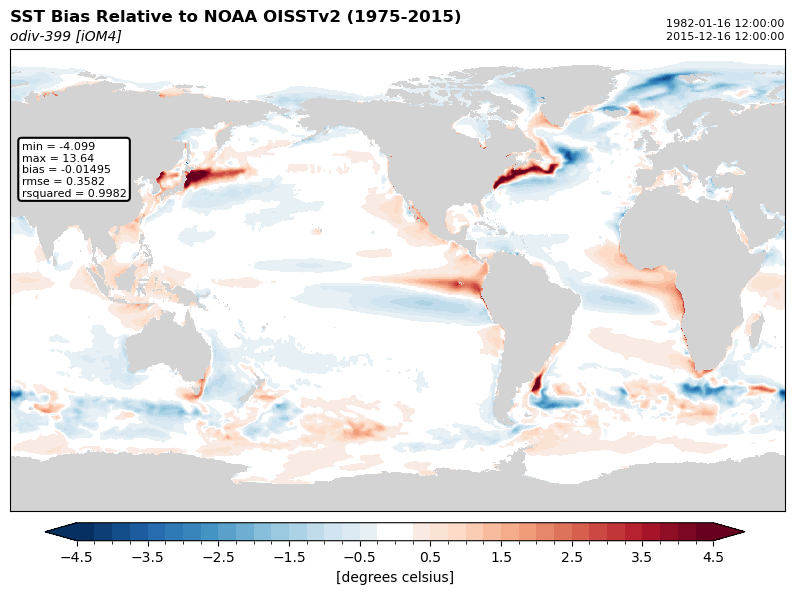

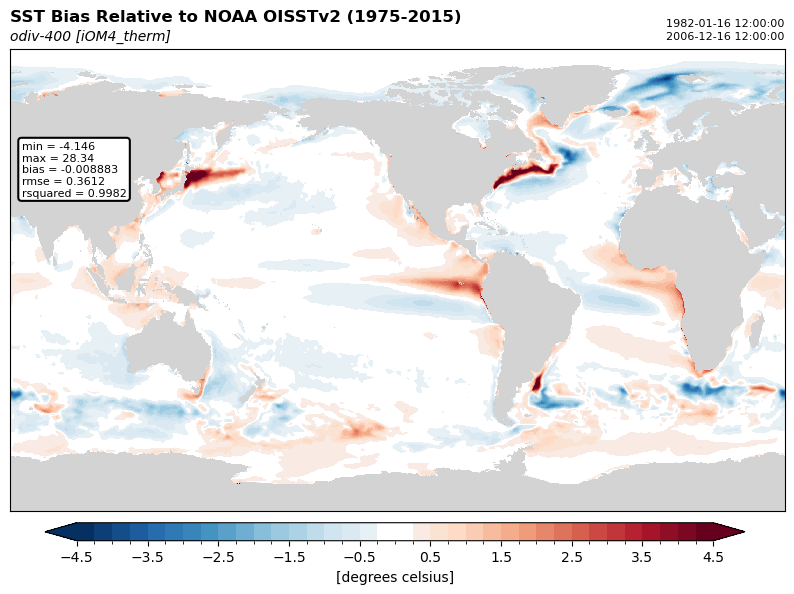

In [58]:
for (odiv, model_dict) in models.items():
    gds = model_dict["gds"]
    
    # Time-average the model data
    model = gds.data.tos
    starttime = model.time[0]
    endtime = model.time[-1]
    model = momlevel.util.annual_average(model).mean("time", keep_attrs=True).load()
    
    # Obs data is already a climatology
    obs = model_dict["dsobs"].tos
    
    # Setup plot
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(1,1,1, facecolor="lightgray")
    
    # Definie geolon and geolat for plotting (use corners!)
    x = gds.data.geolon_c
    y = gds.data.geolat_c
    
    # Get colormap
    cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)
    
    # Run pcolormesh
    cb = plt.pcolormesh(x,y,model-obs, cmap=cmap, norm=norm)
    
    # Clean up figure and add labels
    set_annotaions(ax, odiv)
    
    # Add statistics
    stats, stats_str = calculate_stats(model, obs, gds.data.areacello)
    add_stats_box(ax, stats_str)
    
    # Add colorbar
    add_colorbar(fig, cb, boundaries)

# Plotting inter-model differences

In [59]:
def set_annotaions_diff(ax, odiv, odiv_ref):
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    _ = ax.text(0.0,1.06, "SST (1975-2015)", weight="bold", fontsize=12, transform=ax.transAxes)
    _ = ax.text(0.0,1.02, rf"Difference = {odiv} [{params[odiv]['expName']}] $-$ {odiv_ref} [{params[odiv_ref]['expName']}]", style="italic", fontsize=10, transform=ax.transAxes)
    _ = ax.text(1.0,1.05, str(starttime.values), ha="right", fontsize=8, transform=ax.transAxes)
    _ = ax.text(1.0,1.02, str(endtime.values), ha="right", fontsize=8, transform=ax.transAxes)

/nbhome/ogrp/python/envs/py311_20240607/lib/python3.11/site-packages/momgrid/classes.py:750: UserWarning: Unsupported grid type: 
  warnings.warn(str(exc))
/nbhome/ogrp/python/envs/py311_20240607/lib/python3.11/site-packages/momgrid/external.py:111: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/envs/py311_20240607/lib/python3.11/site-packages/momgrid/classes.py:750: UserWarning: Weights file not found on disk.
/nbhome/John.Krasting/grid_weights/c_sym_bilinear_0x0_720x1440.nc
  warnings.warn(str(exc))
/nbhome/ogrp/python/envs/py311_20240607/lib/python3.11/site-packages/momgrid/classes.py:750: UserWarning: Unsupported grid type: 
  warnings.warn(str(exc))
/nbhome/ogrp/python/envs/py311_20240607/lib/python3.11/site-packages/momgrid/external.py:111: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/envs/py311_20240607/lib/python3.11/site-packages/momgrid/classes.py:750: UserWarning: Weights file

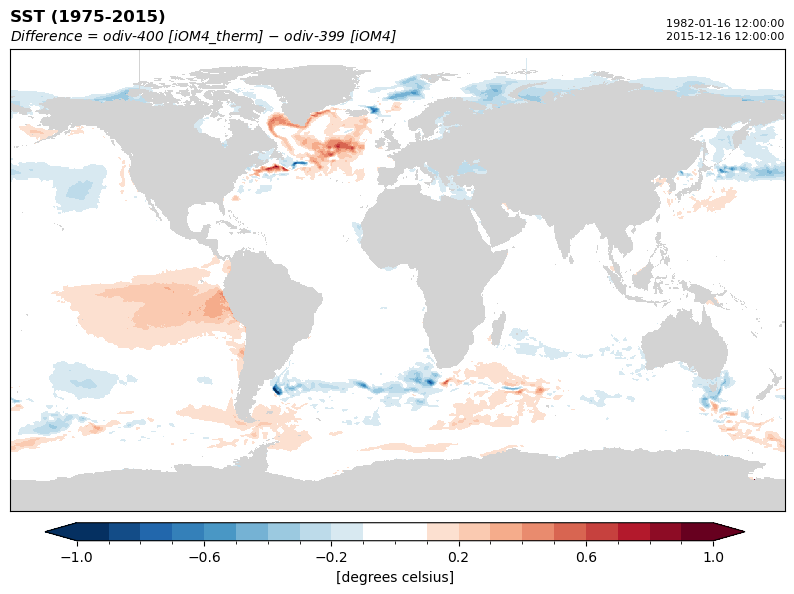

In [60]:
first = True

if len(models)==1: 
    print("No difference plot because only one experiment ID was provided!")

else:
    for (odiv, model_dict) in models.items():
        if first:
            first = False
            gds_ref = model_dict["gds"].regrid(resolution=0.25)
            odiv_ref = odiv
            continue
            
        gds = model_dict["gds"].regrid(resolution=0.25)
        
        # Time-average the model data
        model = gds.tos
        starttime = model.time[0]
        endtime = model.time[-1]
        model = momlevel.util.annual_average(model).mean("time", keep_attrs=True).load()
    
        model_ref = gds_ref.tos
        starttime = model_ref.time[0]
        endtime = model_ref.time[-1]
        model_ref = momlevel.util.annual_average(model_ref).mean("time", keep_attrs=True).load()
        
        # Setup plot
        fig = plt.figure(figsize=(10,6))
        ax = plt.subplot(1,1,1, facecolor="lightgray")
        
        # Definie geolon and geolat for plotting (use corners!)
        x = gds.lon_b
        y = gds.lat_b
        
        # Get colormap
        cmap, norm, boundaries = gen_levs_and_cmap(-1,1.1,0.1)
        
        # Run pcolormesh
        cb = plt.pcolormesh(x,y,model-model_ref, cmap=cmap, norm=norm)
        
        # Clean up figure and add labels
        set_annotaions_diff(ax, odiv, odiv_ref)
    
        # Add colorbar
        add_colorbar(fig, cb, boundaries)